# Phys 512: Assignment 3
## by: Christian Ivanov 260808189

## Question 1

To find $\chi ^2$, all we need to do is fit the function to the parameters we're given and compute it using $\chi ^2 = \sum (\frac{data-model}{error})^2$

In [161]:
import numpy as np
import camb
from matplotlib import pyplot as plt
from matplotlib import gridspec

In [162]:
def get_spectrum(pars,lmax=1199): #setting default lmax such that the output array is the same length as the data
    H0=pars[0]                    #this makes it faster and easier to use for the rest of the assignment
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0][2:]                #discarding the first two terms which give zero
    return tt

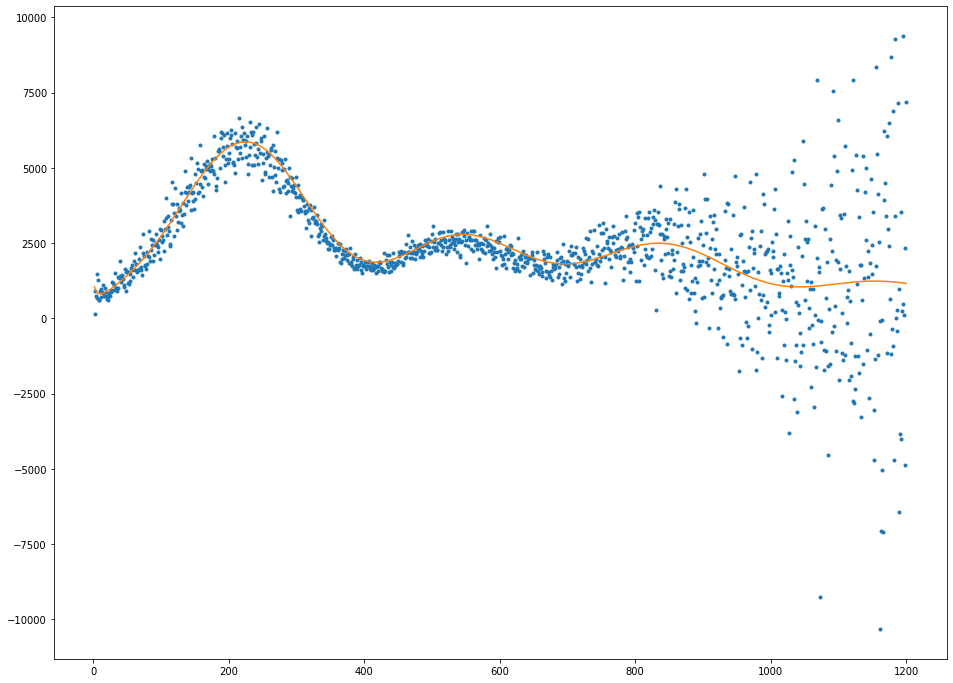

In [163]:
pars=np.asarray([65,0.02,0.1,0.05,2e-9,0.96])
wmap=np.loadtxt('wmap_tt_spectrum_9yr_v5.txt')
cmb=get_spectrum(pars)
plt.figure(figsize=(16,12))
plt.plot(wmap[:,0],wmap[:,1],'.');plt.plot(wmap[:,0],cmb)

In [164]:
def get_chisq(data,model,sigma):
    return np.sum((data-model)**2/sigma**2)

chis=get_chisq(wmap[:,1],cmb,wmap[:,2])
print('chi square is:',chis)

chi square is: 1588.4366720631901


As we can see, the fit is pretty close, but not perfect; it misses out on the second bump in particular. We expected a $\chi ^2 \approx 1588$ and it's exacty what we got, with $\chi ^2 = 1588.4366720631901$ 

## Question 2

First, I will set up a function which will estimate the partial derivatives of the fit relative to each parameter by measuring how the fit changes if the given parameter shifts a bit. To do this, I will evaluate the function a given fraction of the parameter above and below its original value, or in other words, use $\frac{\partial f}{\partial x} = \frac{f(x + \delta x) - f(x - \delta x)}{2\delta x}$ I chose that fraction to be $\delta = \frac{1}{1000}$ and it seems to give decent results.

In [165]:
def slope(y,n,p,ratio=1000):
    dpp = np.zeros(p.size)
    dpm = np.zeros(p.size)
    for i in range(p.size):
        if i == n:
            dpp[i] = p[i]+(p[i]/ratio)
            dpm[i] = p[i]-(p[i]/ratio)
        else:
            dpp[i] = p[i]
            dpm[i] = p[i]
        
    return (y(dpp) - y(dpm))*0.5*ratio/p[n]

In [166]:
def calc_grad(p):
    y=get_spectrum(p)
    grad=np.zeros([y.size,p.size])
    for i in range(p.size):
            grad[:,i]=slope(get_spectrum,i,p)
    return y,grad

Now, we run the algorithm for Newton's method, but keeping $\tau$ fixed. The simplest way I found to do this is to ignore its partial derivetives, run the algorithm without them, and then vary the other parameters, keeping $\tau$ fixed.

[6.22360351e+01 2.19347796e-02 1.21087086e-01 5.00000000e-02
 2.08224357e-09 9.44117993e-01] 1588.4366720631901
[6.33881545e+01 2.20861080e-02 1.21631137e-01 5.00000000e-02
 2.07975662e-09 9.50830073e-01] 1269.1901495503525
[6.32795080e+01 2.20585230e-02 1.21787203e-01 5.00000000e-02
 2.08017300e-09 9.50025403e-01] 1245.3416232779457
[6.33513427e+01 2.20731542e-02 1.21648602e-01 5.00000000e-02
 2.07948451e-09 9.50464434e-01] 1245.6111243443274
[6.31720230e+01 2.20404183e-02 1.22012507e-01 5.00000000e-02
 2.08134921e-09 9.49419332e-01] 1245.4837375286584


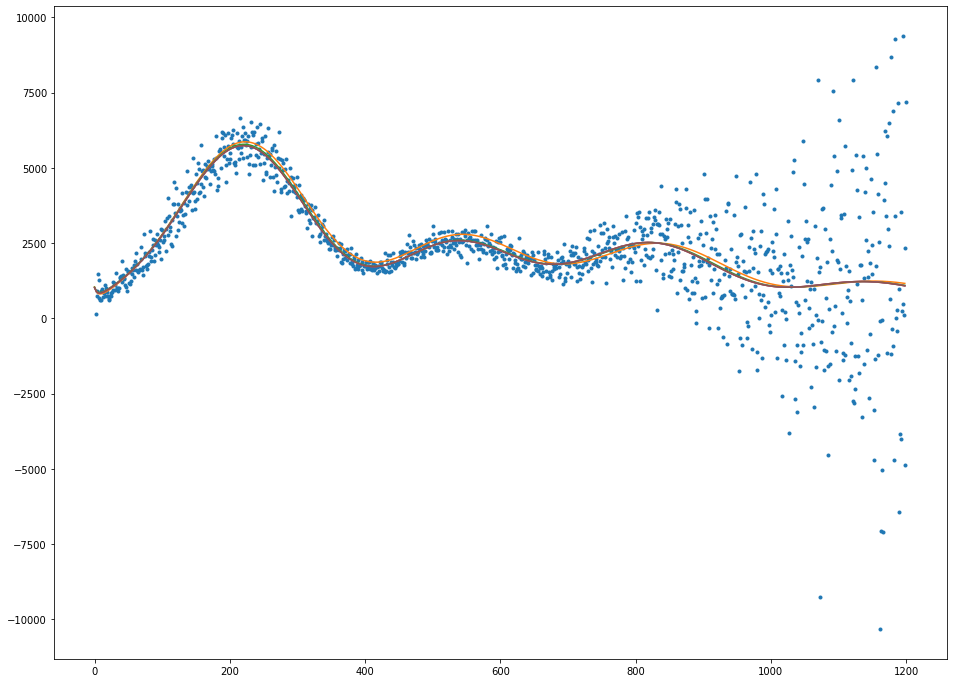

In [167]:
p=pars.copy()
plt.figure(figsize=(16,12))
plt.plot(wmap[:,0],wmap[:,1],'.')
for j in range(5):
    pred,grad=calc_grad(p)
    grad_new = np.delete(grad,3,axis=1)     #we're not varrying tau, so we ignore its gradient
    r=wmap[:,1]-pred
    chi=np.sum((r/wmap[:,2])**2)
    r=np.matrix(r).transpose()
    grad_new=np.matrix(grad_new)

    lhs=grad_new.transpose()*grad_new
    rhs=grad_new.transpose()*r
    dp=np.linalg.inv(lhs)*(rhs)
    for i in range(p.size):
        if i < 3:
            p[i]=p[i]+dp[i]
        elif i == 3:
            p[i]=pars[3]               #and we're stitching tau back into the parameters
        else:
            p[i]=p[i]+dp[i-1]
    
    print(p,chi)
    plt.plot(pred)

Using Newton's Method, we see that after 3 steps, Chi Square reaches about 1245 and stops decreasing, meaning it has converged to an answer, most likley a local minimum. As we can see on the graph above, the fits get progressively better with each iteration, and so the derivative estimates must have been correct.

Using the results of the last Newton's Method step, I then estimate the covariance matrix for all parameters, given by $K \approx (A^T N^{-1} A)^{-1}$ and use it to estimate the error in the parameters. I will also later use it in part 3 to generate steps for the MCMC.

In [168]:
N = np.diag(wmap[:,2])
cov = np.linalg.inv(grad.transpose()@np.linalg.inv(N)@grad)
err = np.zeros(p.size)

for i in range(p.size):
    err[i] = cov[i,i]**0.5
    
print(err)
print(cov)

[1.82145544e-01 4.24140409e-05 3.82576258e-04 6.97767740e-03
 2.80926854e-11 1.32165076e-03]
[[ 3.31769992e-02  6.14060080e-06 -6.49896437e-05  8.99710265e-04
   3.43348483e-12  2.15098263e-04]
 [ 6.14060080e-06  1.79895087e-09 -9.89567038e-09  2.14316884e-07
   8.57399914e-16  5.08006213e-08]
 [-6.49896437e-05 -9.89567038e-09  1.46364593e-07 -1.71133067e-06
  -6.34136867e-15 -3.95036586e-07]
 [ 8.99710265e-04  2.14316884e-07 -1.71133067e-06  4.86879820e-05
   1.95543414e-13  7.53538028e-06]
 [ 3.43348483e-12  8.57399914e-16 -6.34136867e-15  1.95543414e-13
   7.89198972e-22  2.98277079e-14]
 [ 2.15098263e-04  5.08006213e-08 -3.95036586e-07  7.53538028e-06
   2.98277079e-14  1.74676073e-06]]


In [183]:
print('H0 is',p[0],'+/-',err[0])
print('ombh2 is',p[1],'+/-',err[1])
print('omch2 is',p[2],'+/-',err[2])
print('tau is',p[3],'+/-',err[3])
print('As is',p[4],'+/-',err[4])
print('ns is',p[5],'+/-',err[5])
print('chi squared is',chi)

H0 is 63.172023000868705 +/- 0.18214554408313205
ombh2 is 0.022040418320130508 +/- 4.241404089873978e-05
omch2 is 0.12201250672192318 +/- 0.000382576258121924
tau is 0.05 +/- 0.006977677404525398
As is 2.0813492064635072e-09 +/- 2.809268538976355e-11
ns is 0.9494193324472785 +/- 0.0013216507601221312
chi squared is 1245.4837375286584


The parameters it Newton's Method converged to are: $H_0 = 63.2 \pm 0.1$, $\omega_b h^2 = 0.02204 \pm 0.00003 $, $\omega_c h^2 = 0.1210 \pm 0.0003$, $\tau = 0.05 \pm 0.007$, $A_s = (2.081 \pm 0.002) \times 10^{-9}$ and $n_s = 0.9494 \pm 0.0008$ which are all fairly close to the original values, and yet $\chi ^2$ went down from $1588$ to $1245$: a significant improvement! Note that we did not varry $\tau$, so it stays the same, but we did get an estimate of its error from the covariance matrix.

## Question 3

I will use the covariance matrix estimate from question 2 to get the steps for my chain. I will start with the parameters obtained by Newton's method and thus the $\chi ^2$ obtained as well. 

After some testing, I found that a scale factor of 10-12 gives an acceptance rate close around the 25% we should aim for, so I went with 12 and let it run for 5000 steps, which took approximately 45 minutes on my computer

To know when to stop the chain if something goes wrong, I also made it print out the acceptance rate every after 10 steps it takes. I then plotted the evolution of $\chi ^2$ so we get an idea of what's going on.

In [170]:
def take_step_cov(covmat):
    mychol=np.linalg.cholesky(covmat)
    return np.dot(mychol,np.random.randn(covmat.shape[0]))

acceptance rate after 10 steps taken is 18.867924528301888 %
acceptance rate after 20 steps taken is 21.73913043478261 %
acceptance rate after 30 steps taken is 24.0 %
acceptance rate after 40 steps taken is 26.490066225165563 %
acceptance rate after 50 steps taken is 28.089887640449437 %
acceptance rate after 60 steps taken is 28.169014084507044 %
acceptance rate after 70 steps taken is 28.34008097165992 %
acceptance rate after 80 steps taken is 27.972027972027973 %
acceptance rate after 90 steps taken is 27.77777777777778 %
acceptance rate after 100 steps taken is 26.455026455026456 %
acceptance rate after 110 steps taken is 26.252983293556085 %
acceptance rate after 120 steps taken is 24.896265560165975 %
acceptance rate after 130 steps taken is 22.68760907504363 %
acceptance rate after 140 steps taken is 22.508038585209004 %
acceptance rate after 150 steps taken is 22.058823529411764 %
acceptance rate after 160 steps taken is 22.22222222222222 %
acceptance rate after 170 steps take

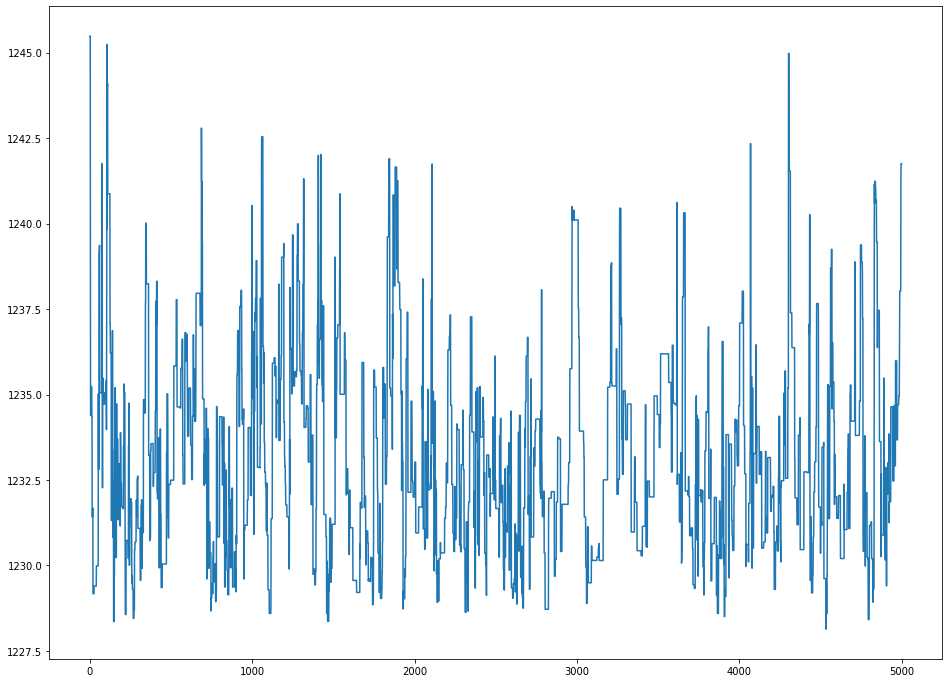

In [20]:
params = p.copy()                #I'musing the results from Newton's Method as a starting point
covmat = np.asarray(cov)
chisq = chi.copy()
nstep=5000
scale_fac=12
chains=np.zeros([nstep,params.size])
chisqvec=np.zeros(nstep)

steps_attempted = 0
steps_taken = 0

for i in range(nstep):
    steps_attempted +=1
    step = take_step_cov(covmat)
    new_params=params+step*scale_fac
    new_model=get_spectrum(new_params)
    new_chisq=get_chisq(wmap[:,1],new_model,wmap[:,2])
    delta_chisq=new_chisq-chisq
    prob=np.exp(-0.5*delta_chisq)
    
    accept=np.random.rand(1)<prob and new_params[3]>0    #do not accept steps with negative tau

    if accept:
        steps_taken += 1
        params=new_params
        model=new_model
        chisq=new_chisq
        
        if steps_taken%10 == 0:         #printing acceptance rate every 10 steps to know if it's working
            print("acceptance rate after",steps_taken, "steps taken is",100*steps_taken/steps_attempted,'%')

    chains[i,:]=params
    chisqvec[i]=chisq
            
fit_params=np.mean(chains[np.int(nstep/2):,:],axis=0)
print(fit_params)
plt.figure(figsize=(16,12))
plt.plot(chisqvec)

We can see that across the run, the acceptance rate slowly dropped and stabilised around 20%, meaning a slightly smaller step size would have been preferable, but this is good enough. Looking at the $\chi ^2$ plot, we see that it rapidly dropped from the 1245 we got from Newton's Method down to around 1230, and it stayed there until the end, with occasional jumps in the 1240s. This isn't that big of an improvement, but it does show that there was more accuracy to be had beyond what we could obtain with Newton.

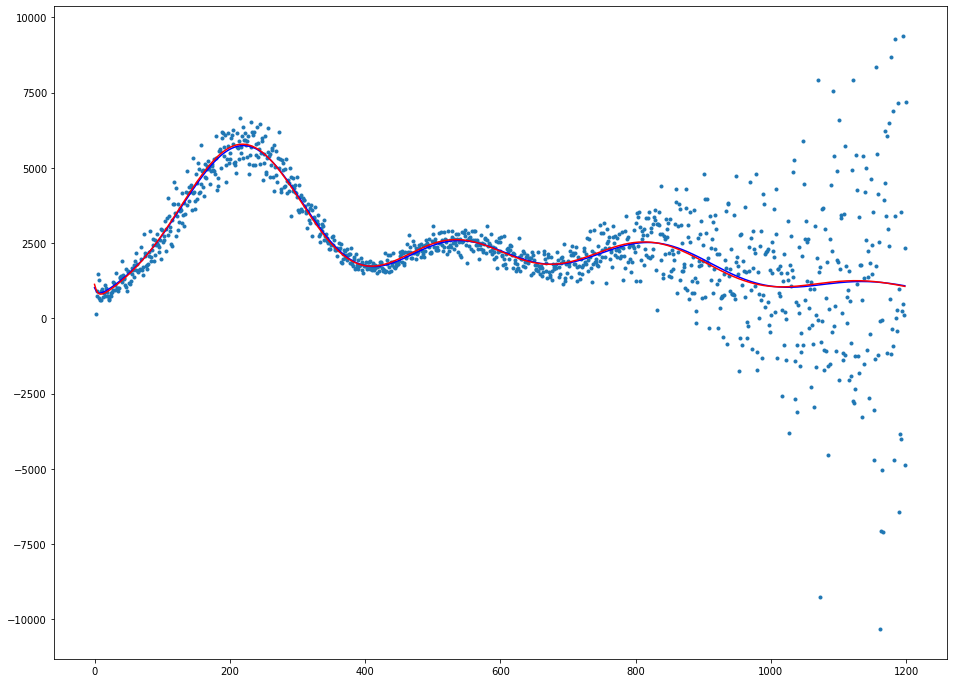

In [194]:
mcmc_fit=get_spectrum(fit_params)
plt.figure(figsize=(16,12))
plt.plot(wmap[:,0],wmap[:,1],'.');plt.plot(pred,'-b');plt.plot(mcmc_fit,'-r')

Taking the second half of the chains to compute the new parameters and their uncertanties, I plotted the fit obtained with the MCMC (red) versus what we obtained earlier with Newton's Method (blue). As we can see, both are very close to one-another, and it's difficult to tell which fits the data at a glance.

In [188]:
newcov = np.cov(chains[np.int(nstep/2):,:].T)
error = np.zeros(params.size)

for i in range(params.size):
    error[i] = newcov[i,i]**0.5

print('H0 is',fit_params[0],'+/-',error[0])
print('ombh2 is',fit_params[1],'+/-',error[1])
print('omch2 is',fit_params[2],'+/-',error[2])
print('tau is',fit_params[3],'+/-',error[3])
print('As is',fit_params[4],'+/-',error[4])
print('ns is',fit_params[5],'+/-',error[5])
print('chi squared is',get_chisq(wmap[:,1],mcmc_fit,wmap[:,2]))

H0 is 71.11521775870806 +/- 2.767829920833481
ombh2 is 0.02297397739660206 +/- 0.0005538787325063955
omch2 is 0.11116331701914015 +/- 0.005805465189572111
tau is 0.11522753544132168 +/- 0.057739849984357675
As is 2.331364257451489e-09 +/- 2.534285958224637e-10
ns is 0.9874215699173062 +/- 0.017713818683128
chi squared is 1229.9846961060032


In particular, the parameters obtained with MCMC are: $H_0 = 71 \pm 3$, $\omega_b h^2 = 0.0220 \pm 0.0006 $, $\omega_c h^2 = 0.111 \pm 0.005$, $\tau = 0.12 \pm 0.06$, $A_s = (2.3 \pm 0.3) \times 10^{-9}$ and $n_s = 0.99 \pm 0.02$ which gives a $\chi ^2 = 1230$, a little bit better than what we got with Newton's Method.

On the other hand, the error estimates here are larger than what we got with Newton, and some of the parameters have changed noticeably: $\tau$ more than doubled! This indicates there's a fairly large family of parameters which can fit the data equally well, and that the error estimates Newton's Method gave us were too conservative. This makes sence, as we had kept Tau fixed, which restricted how the other parameters could vary while maintaining a good fit.

To more accurately check whether the chains have converged or not, I will now plot the chains and their fourrier transforms so we can have a more detaield look at their behaviour.

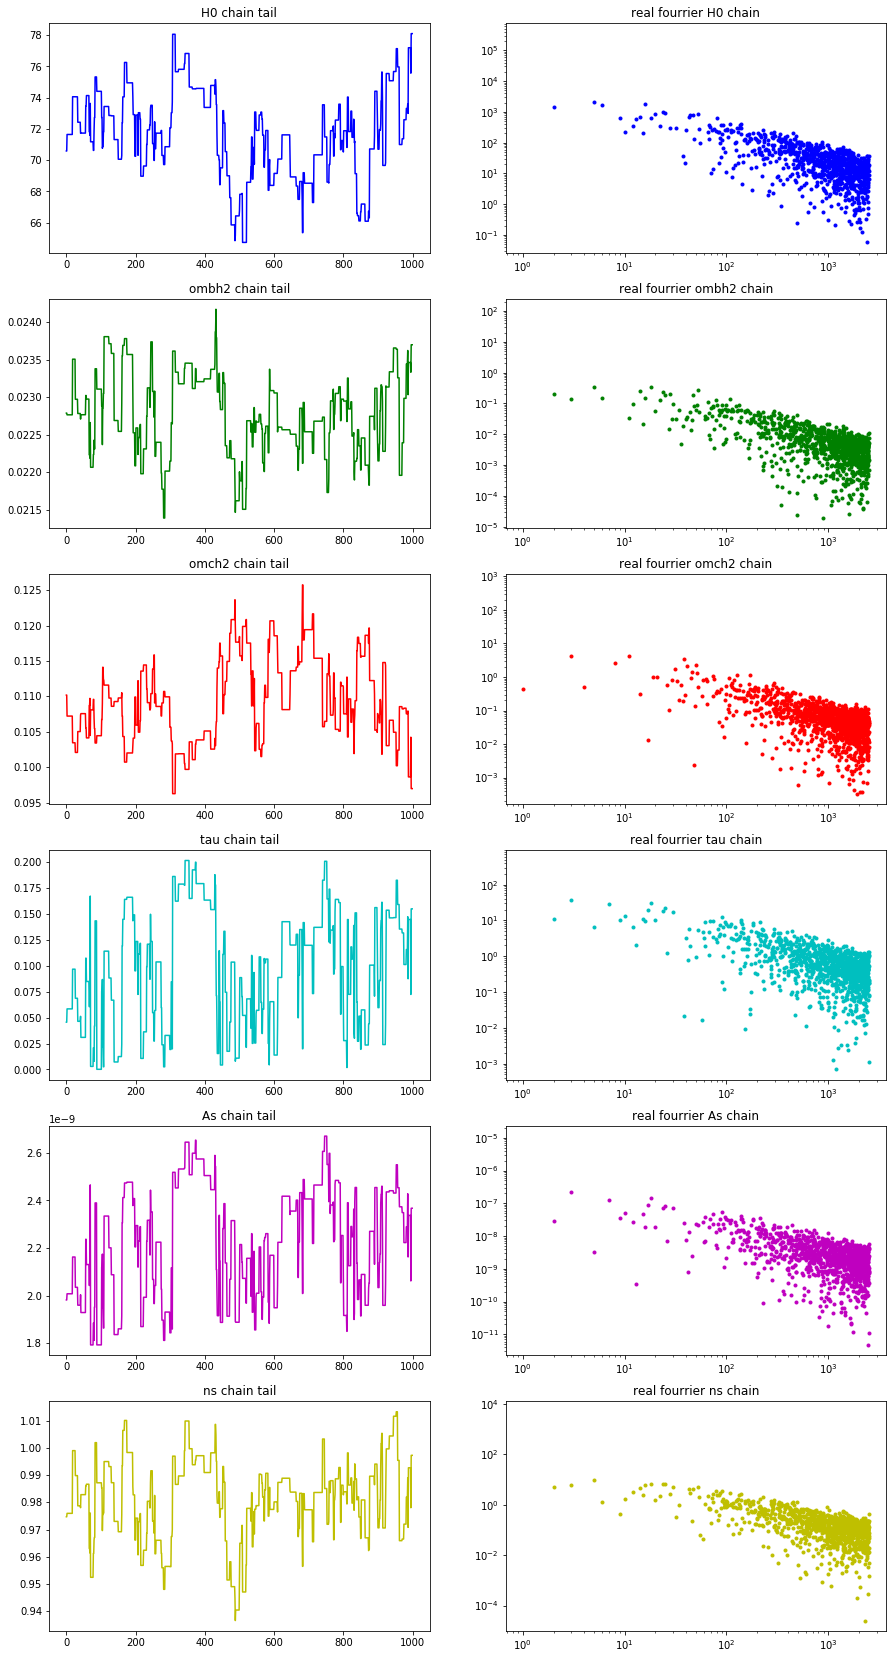

In [195]:
f_chains=np.zeros([np.int(nstep/2)+1,params.size])
for i in range(params.size):
    f_chains[:,i] = np.real(np.fft.rfft(chains[:,i]))

fig = plt.figure(figsize=(15,60))
spec = gridspec.GridSpec(ncols=2, nrows=12, figure=fig)

fig.add_subplot(spec[0, 0])
plt.plot(chains[:,0][4000:],'-b')
plt.title("H0 chain tail")
fig.add_subplot(spec[0, 1])
plt.loglog(f_chains[:,0],'.b')
plt.title("real fourrier H0 chain")
fig.add_subplot(spec[1, 0])
plt.plot(chains[:,1][4000:],'-g')
plt.title("ombh2 chain tail")
fig.add_subplot(spec[1, 1])
plt.loglog(f_chains[:,1],'.g')
plt.title("real fourrier ombh2 chain")
fig.add_subplot(spec[2, 0])
plt.plot(chains[:,2][4000:],'-r')
plt.title("omch2 chain tail")
fig.add_subplot(spec[2, 1])
plt.loglog(f_chains[:,2],'.r')
plt.title("real fourrier omch2 chain")
fig.add_subplot(spec[3, 0])
plt.plot(chains[:,3][4000:],'-c')
plt.title("tau chain tail")
fig.add_subplot(spec[3, 1])
plt.loglog(f_chains[:,3],'.c')
plt.title("real fourrier tau chain")
fig.add_subplot(spec[4, 0])
plt.plot(chains[:,4][4000:],'-m')
plt.title("As chain tail")
fig.add_subplot(spec[4, 1])
plt.loglog(f_chains[:,4],'.m')
plt.title("real fourrier As chain")
fig.add_subplot(spec[5, 0])
plt.plot(chains[:,5][4000:],'-y')
plt.title("ns chain tail")
fig.add_subplot(spec[5, 1])
plt.loglog(f_chains[:,5],'.y')
plt.title("real fourrier ns chain")

plt.show()

The graps above show the tail (last 1000 terms) as well of the real part of the fourrier transform of each of the chains. As we can see, the tails mostly ressemble zoomed-in flat white noise while the fourrier transforms appear mostly flat at lower frequencies, both indicators that the chains have converged.

Note that the chains of some parameters do seem to be noticeably corelated, in particular, almost all of them have a noticeable "bump" to the left of the middle of their tail graphs, but the individual graphs still look like white noise from afar. To get better resolution, longer chains would probably be favourable, but given the long computation times, this is good enough. 

## Question 4

To add $\tau = 0.0544 \pm 0.0073$ as a prior to our chain, I will simply weight the old chains by how closely their value s for $\tau$ match the prior, as evaluated by a gaussian distribution centered at $\tau =  0.0544$ with width $\sigma = 0.0073$. I will then do the same for the covariance matrix to get errors on the new parameters

In [179]:
def gaussian(x,sigma,avg):
    return np.exp(-0.5*((x-avg)/sigma)**2)/(sigma*(2*np.pi)**0.5)

In [180]:
tau_vals = chains[:,3]
tau = 0.0544
sigma_tau = 0.0073
weights = gaussian(tau_vals,sigma_tau,tau)
new_covmat = np.cov(chains[np.int(nstep/2):,:].T,aweights=weights[np.int(nstep/2):])
new_params = np.average(chains,axis=0,weights=weights)
print(new_params)
print(new_covmat)

[6.91494563e+01 2.25072580e-02 1.14494369e-01 5.52269182e-02
 2.06888555e-09 9.70863263e-01]
[[ 7.05381573e+00  7.25482456e-04 -1.39827979e-02  2.07095874e-03
  -9.10137080e-11  1.93757610e-02]
 [ 7.25482456e-04  1.96135778e-07 -8.53518376e-07  5.06135116e-07
  -1.41515044e-15  3.55190353e-06]
 [-1.39827979e-02 -8.53518376e-07  3.48773847e-05 -2.04014899e-06
   2.61784015e-13 -3.70553631e-05]
 [ 2.07095874e-03  5.06135116e-07 -2.04014899e-06  5.02760441e-05
   2.09917591e-13  1.82406132e-05]
 [-9.10137080e-11 -1.41515044e-15  2.61784015e-13  2.09917591e-13
   3.12641502e-21 -1.41521562e-13]
 [ 1.93757610e-02  3.55190353e-06 -3.70553631e-05  1.82406132e-05
  -1.41521562e-13  1.10625988e-04]]


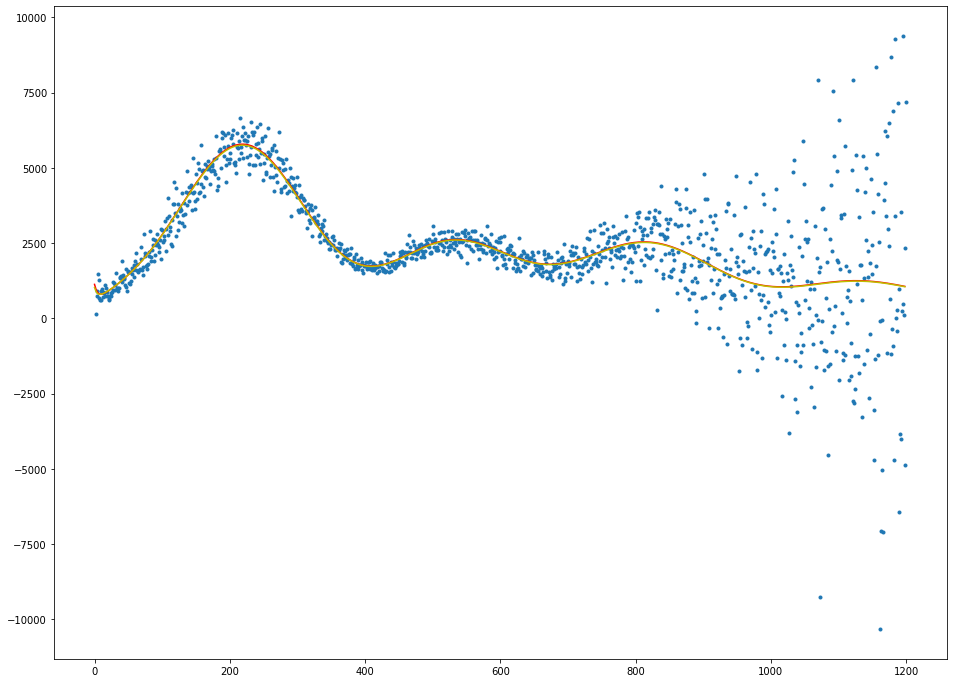

In [204]:
mcmc_new=get_spectrum(new_params)
plt.figure(figsize=(16,12))
plt.plot(wmap[:,0],wmap[:,1],'.');plt.plot(mcmc_fit,'-r');plt.plot(mcmc_new,'-y')

As we can see, the new MCMC fit (yellow) and the fit using the old MCMC fit (red) almost perfectly overlap and are virtually indistinguishgable from one-another. Both fit the data exceptionally well.

In [205]:
new_error = np.zeros(params.size)
for i in range(params.size):
    new_error[i] = new_covmat [i,i]**0.5

print('H0 is',new_params[0],'+/-',new_error[0])
print('ombh2 is',new_params[1],'+/-',new_error[1])
print('omch2 is',new_params[2],'+/-',new_error[2])
print('tau is',new_params[3],'+/-',new_error[3])
print('As is',new_params[4],'+/-',new_error[4])
print('ns is',new_params[5],'+/-',new_error[5])
print('chi squared is',get_chisq(wmap[:,1],mcmc_new,wmap[:,2]))

H0 is 69.14945625665061 +/- 2.6559020549670596
ombh2 is 0.02250725804587414 +/- 0.00044287219117170214
omch2 is 0.11449436861096506 +/- 0.005905707808742219
tau is 0.05522691821073317 +/- 0.007090560208003734
As is 2.0688855486275776e-09 +/- 5.591435429894157e-11
ns is 0.970863263355474 +/- 0.010517888956239911
chi squared is 1227.9805179134928


The final parameters we obtained are: $H_0 = 69 \pm 3$, $\omega_b h^2 = 0.0225 \pm 0.0004 $, $\omega_c h^2 = 0.114 \pm 0.006$, $\tau = 0.055 \pm 0.007$, $A_s = (2.07 \pm 0.06) \times 10^{-9}$ and $n_s = 0.97 \pm 0.01$ which gives a $\chi ^2 = 1228$, practically the same as before. Note that by restricting $\tau$, the uncertanties on average dropped a little bit, and in particular, the value of $\tau$ which we get is a slightly more accurate version of the prior probability as we should expect, since we've been given extra information by running the chains.